In [1]:
# Import qiskit and modules
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import time

from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble
from qiskit import Aer
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.circuit.library import TwoLocal

from scipy.optimize import minimize

In [7]:
from AtomLoader import *

In [8]:
################ Tutorial Block ################
# Initializing a three-qubit quantum state
desired_vector = [
    math.cos(np.pi/4),
    0,
    math.cos(np.pi/4),
    0,
    0,
    0,
    0,
    0]


q = QuantumRegister(3)

qc = QuantumCircuit(q)

qc.initialize(desired_vector, [q[0],q[1],q[2]])
qc.draw()

backend = BasicAer.get_backend('statevector_simulator')
job = backend.run(transpile(qc, backend))
qc_state = job.result().get_statevector(qc)
qc_state

state_fidelity(desired_vector,qc_state)

1.0

In [9]:
def training_circuit(parameters, atomic_descriptors):
    
    qc = QuantumCircuit(M)
    qc_descriptor = QuantumCircuit(M)
    
    list_eta = parameters[0:M]
    list_ksi = parameters[M:M + (depth+1)*M*2] ## twolocal have 4M parameters
    
    # for i in range(M):
    for i, descriptor in enumerate(atomic_descriptors):
        qc_descriptor.u(
            descriptor[0],
            descriptor[1],
            0,
            i
            ) #should be replaced to theta(list_eta[i]), phi(list_ksi[i])
        #Young Oh should read this!

    twolocal = TwoLocal(num_qubits=M, reps=depth, rotation_blocks=['ry','rz'], 
                   entanglement_blocks='cx', entanglement='circular', parameter_prefix='ξ', insert_barriers=True)
    twolocal = twolocal.bind_parameters(list_ksi)
    
    qc += qc_descriptor
    qc.barrier()

    qc += twolocal
    qc.barrier()

    #Observable
    qc.z(0)

    qc.barrier()

    qc += twolocal.inverse()
    qc.barrier()

    qc += qc_descriptor.inverse()
    qc.barrier()
    
    return qc

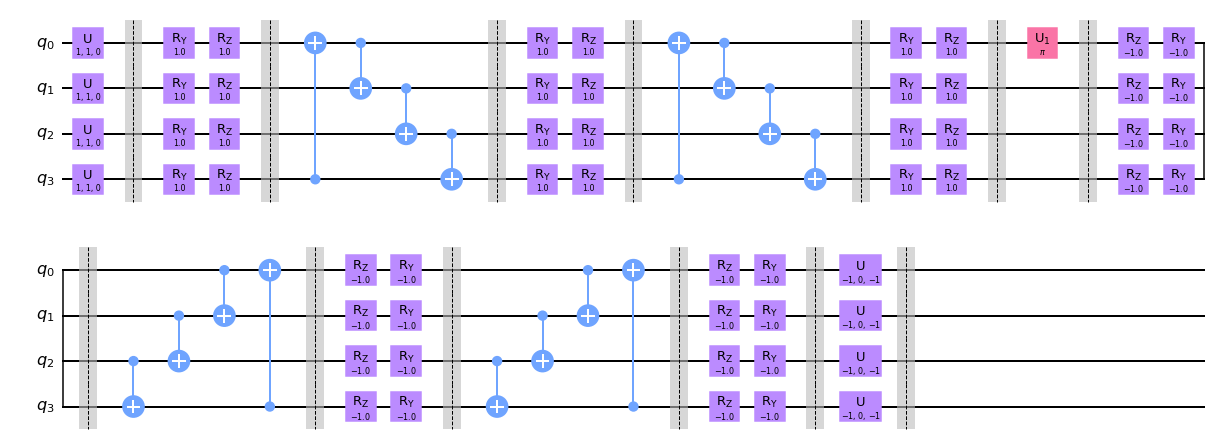

In [4]:
M=4 #Number of descriptors (features)
depth = 2 #Number of repetitions of layer
len_param = M*(2*depth+3) #Number of total parameters (eta + ksi)

parameters= np.ones(len_param)
qc = training_circuit(parameters)
qc.decompose().draw('mpl')

In [5]:
def calculate_loss_function(parameters, random_indexes):

    
    backend = Aer.get_backend('aer_simulator')
    loss = 0
    for molecule_index in random_indexes:
        energy = 0
        list_eta = parameters[0:M]
        atom_data = AtomLoader(list_eta, idx=molecule_index)
        ground_energy_label = atom_data[molecule_index]['ground_energy']
        descriptors = atom_data[molecule_index]['descriptor']

        # for i in range(0, N):

        for i, atomic_descriptors in enumerate(descriptors):
            qctl = QuantumRegister(M)
            qc = ClassicalRegister(M)
            circ = QuantumCircuit(qctl, qc)
        
            circ += training_circuit(parameters, atomic_descriptors)
            
            circ.save_statevector()
            t_circ = transpile(circ, backend)
            qobj = assemble(t_circ)
            job = backend.run(qobj)

            result = job.result()
            outputstate = result.get_statevector(circ, decimals=100)
            o = outputstate

            energy += np.real(o[0]) ## <0|GdWdOWG|0> is picking first component of GdWdOWG|0>. I don't think square is necessary
        
    return energy

In [58]:
list_theta = [1,2]
list_phi = [1,2]

M = 3 #Number of descriptors (features) = Number of qubits
N = 3 #Number of atoms = Number of circuits
depth = 2 #Number of repetitions of layer
len_param = M*(2*depth+3) #Number of total parameters (eta + ksi)

print("Number of total parameters: ", len_param)

random_indexes = [str(x) for x in (np.random.choice(len(qm9), 100) + 1)]


start = time.time()
out = minimize(calculate_loss_function, 
    x0=[float(random.randint(0,3000))/1000 for i in range(0, len_param)], 
    method="COBYLA", 
    options={'maxiter':200},
    args=(random_indexes)
    )
end = time.time()

print(f"Calculation time: {end-start}s\n")


print(out)

#out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]


Number of total parameters:  21
Calculation time: 31.99201798439026s

     fun: -2.9984632784426566
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 200
  status: 2
 success: False
       x: array([1.57487294, 2.65853293, 0.32543753, 1.43708602, 1.3770849 ,
       0.88513737, 2.16367768, 2.15211282, 2.38289613, 1.51011334,
       1.6804652 , 1.44741413, 1.15134453, 1.0496625 , 3.73654591,
       2.49150215, 1.08076634, 0.83765212, 2.33158709, 2.01079348,
       0.87668337])
